In [1]:
import zipfile
import scipy.io
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import mne
import torch
from torchvision import datasets, transforms
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')
import features
from scipy import stats
from scipy import signal

In [2]:
# Load zip files
zip_map = {
    'fnusa': '/home/mcesped/scratch/Datasets/Dataset_Fnusa_2048.zip', 
    'mayo': '/home/mcesped/scratch/Datasets/Dataset_Mayo_2048.zip'
}
filename_map = {
    'fnusa': 'Dataset_Fnusa/', 
    'mayo': 'Dataset_Mayo/'
}

df_path = '/scratch/mcesped/Datasets/segments_mayo_fnusa_curated_short_version.csv'
df_total = pd.read_csv('/scratch/mcesped/Datasets/segments_mayo_fnusa_curated_short_version.csv', sep=",",index_col="index")

data = {
    'noise': [],
    'pathology': [],
    'physiology': []
}

id_to_name={
    1: 'noise',
    2: 'pathology',
    3: 'physiology'
}

for cat_id in (1,2,3):
    # Get df with category 
    df_tmp = df_total.loc[df_total.category_id == cat_id]
    # Random sample
    df_random = df_tmp.sample(n=10).reset_index(drop=True)
    # Get cat name
    cat_name = id_to_name[cat_id]
    for id in df_random.index:
        # Get inst and id 
        inst = df_random.loc[id,'institution']
        seg_id  = df_random.loc[id,'segment_id']
        file_name = os.path.join(filename_map[inst], seg_id+'.npy')
        zip_file = zip_map[inst]
        with zipfile.ZipFile(zip_file, mode="r") as f:
            # Get all files
            files = f.namelist()
            # print(len(files))
            # print(file_name)
            # Open 1 files to check
            with f.open(file_name) as myfile:
                # data = pd.read_csv(myfile, sep=",", index_col="Unnamed: 0")
                # print(data.head())
                data_tmp = np.load(myfile)
                # print(data.shape)
            # Append to data
            data[cat_name].append(data_tmp)

In [3]:
for cat in data:
    print(len(data[cat]))

10
10
10


## Time plots

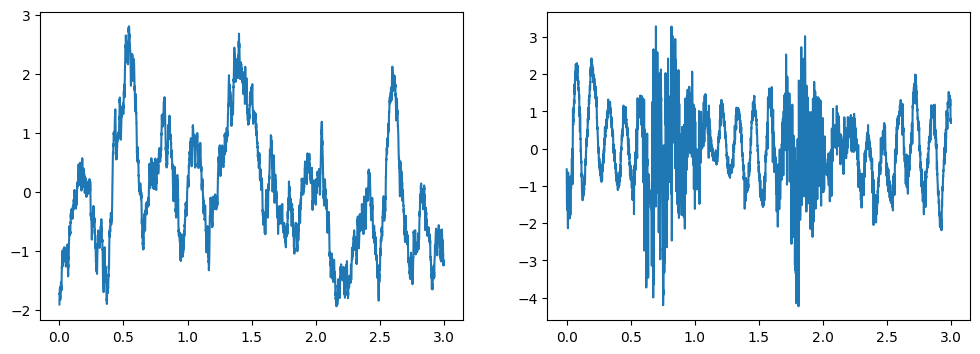

In [6]:
# Noise
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
data_tmp = np.array(data['noise'])
np.random.shuffle(data_tmp)
t = np.arange(0,len(data_tmp[0,:]))/2048
for id, ax in enumerate(axes.flatten()):
    signal_tmp = stats.zscore(data_tmp[id,:])
    ax.plot(t,signal_tmp)

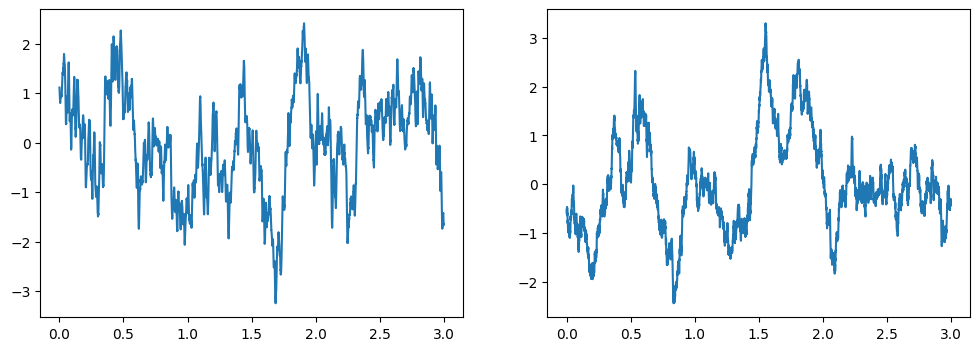

In [14]:
# Physiology
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
data_tmp = np.array(data['physiology'])
np.random.shuffle(data_tmp)
t = np.arange(0,len(data_tmp[0,:]))/2048
for id, ax in enumerate(axes.flatten()):
    signal_tmp = stats.zscore(data_tmp[id,:])
    ax.plot(t,signal_tmp)

## Freq components

In [26]:
import scipy.signal as signal
from scipy import stats

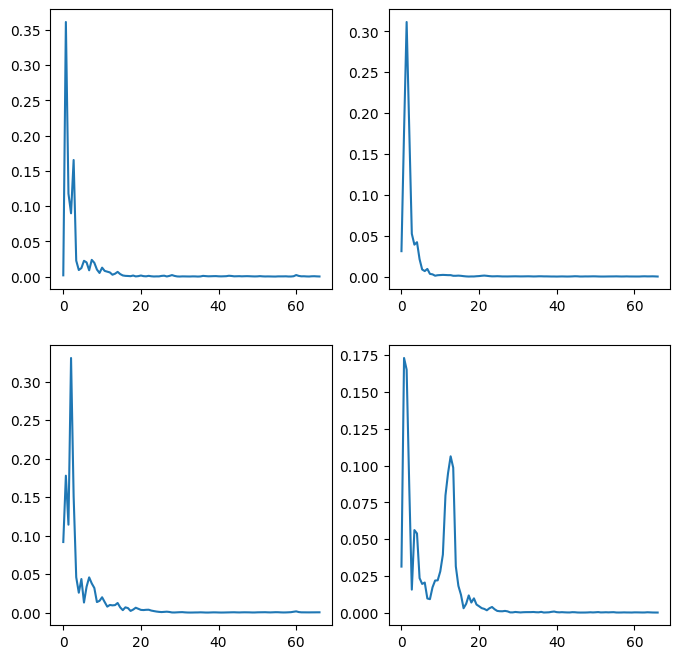

In [130]:
# Noise
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for id, ax in enumerate(axes.flatten()):
    f,Pxx = signal.welch(stats.zscore(data_tmp[id,:]), fs=2048, nperseg=int(len(data_tmp[id,:])/2))
    ax.plot(f[0:100],Pxx[0:100])

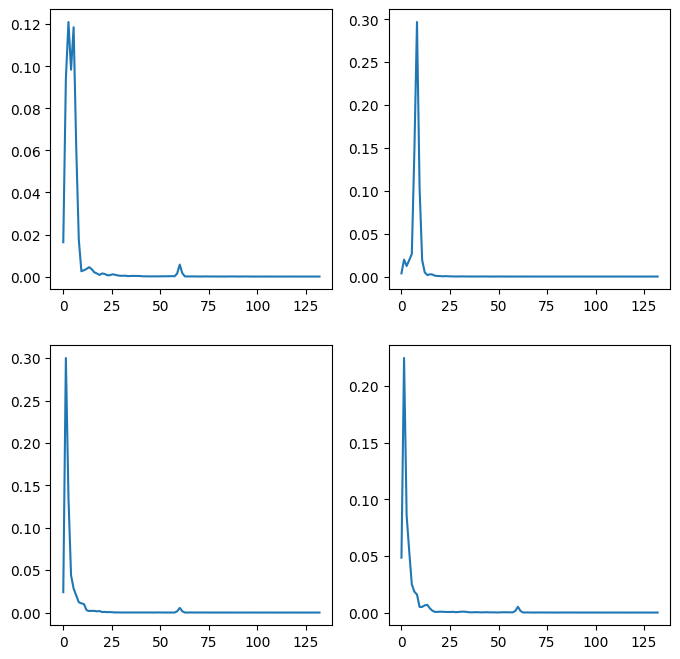

In [133]:
# Noise
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for id, ax in enumerate(axes.flatten()):
    f,Pxx = signal.welch(stats.zscore(data_tmp[id,:]), fs=2048, nperseg=int(len(data_tmp[id,:])/4))
    ax.plot(f[0:100],Pxx[0:100])

## Spectrogram

0.0999014859271065
0.01673150687265118
0.08404397592133786
0.13762674175975745


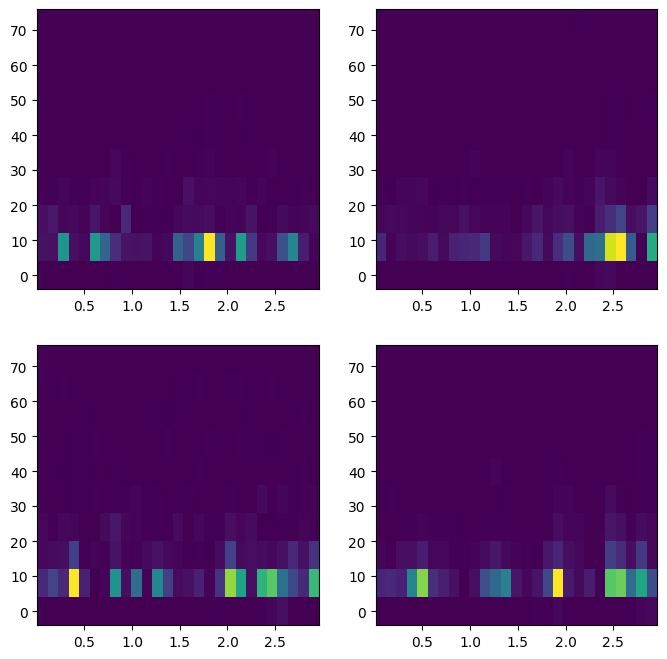

In [20]:
# Noise
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for id, ax in enumerate(axes.flatten()):
    f,t,Sxx = signal.spectrogram(stats.zscore(data_tmp[id,:]), fs=2048)
    ax.pcolormesh(t, f[:10], Sxx[:10,:])
    print(np.max(Sxx))

0.11235953070014792
0.19982092561788695
0.23277444151498167
0.052498183881149504


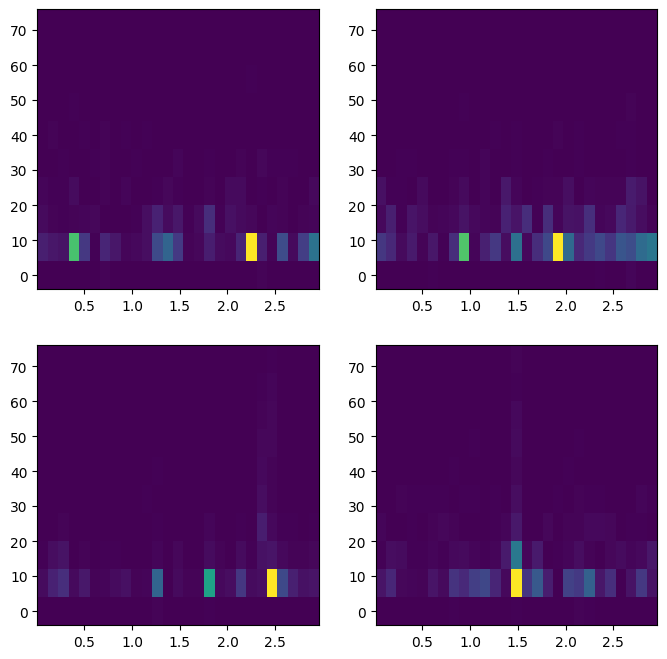

In [23]:
# Physiology
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for id, ax in enumerate(axes.flatten()):
    f,t,Sxx = signal.spectrogram(stats.zscore(data_tmp[id,:]), fs=2048)
    ax.pcolormesh(t, f[:10], Sxx[:10,:])
    print(np.max(Sxx))

## Hilber transform

In [13]:
from features import get_Hilbert_features

10.197056666684892
17.47790658411508
11.136823944489674
12.122014131517705


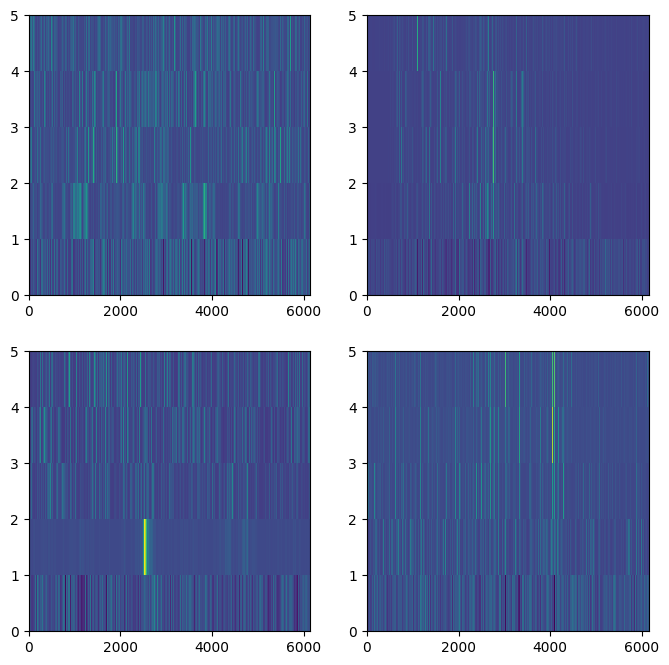

In [32]:
# Noise
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for id, ax in enumerate(axes.flatten()):
    output = get_Hilbert_features(data_tmp[id,:], 2048)
    ax.pcolormesh(output)
    print(np.max(output))

8.566396424037855
9.586632939205078
16.689956162562485
10.00792979652031


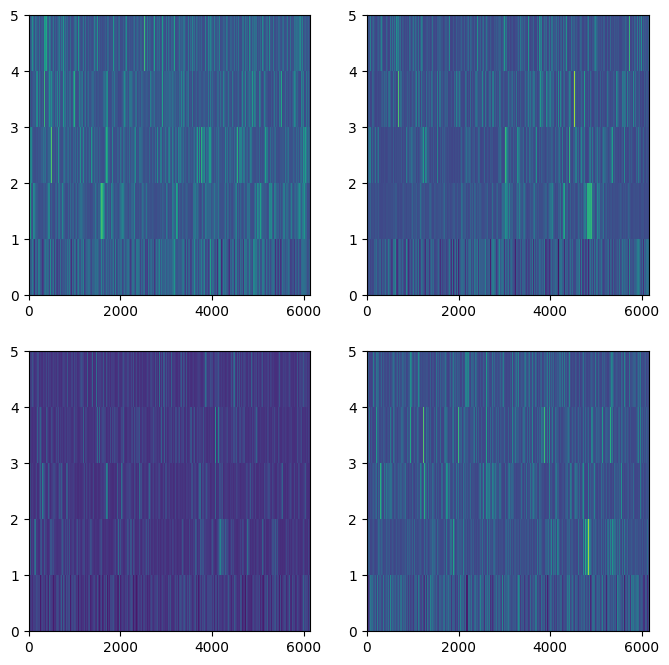

In [28]:
# Physiology
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for id, ax in enumerate(axes.flatten()):
    output = get_Hilbert_features(data_tmp[id,:], 2048)
    ax.pcolormesh(output)
    print(np.max(output))

## Combined maps

In [7]:
from features import get_Hilbert_CWT_features

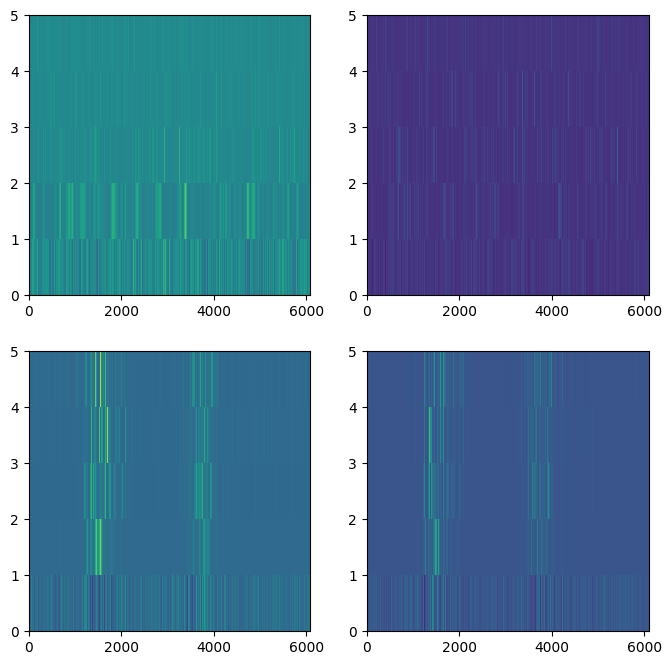

In [12]:
# Noise
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
flat_axes = axes.flatten()
for id in range(2):
    output = get_Hilbert_CWT_features(data_tmp[id,:], 2048)
    flat_axes[2*id].pcolormesh(output[0,:,:])
    flat_axes[2*id+1].pcolormesh(output[1,:,:])
    
        # print(np.max(output))

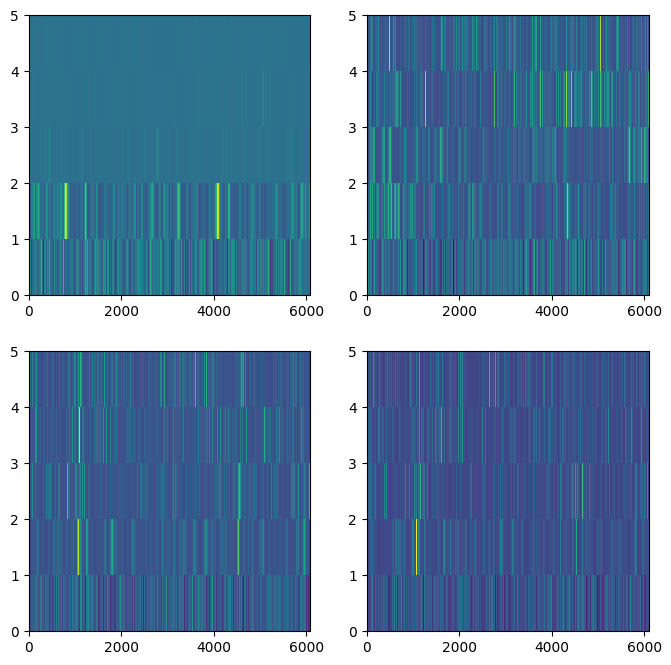

In [15]:
# Physiology
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
flat_axes = axes.flatten()
for id in range(2):
    output = get_Hilbert_CWT_features(data_tmp[id,:], 2048)
    flat_axes[2*id].pcolormesh(output[0,:,:])
    flat_axes[2*id+1].pcolormesh(output[1,:,:])
    
        # print(np.max(output))

## Statistical properties

In [66]:
from scipy.stats import kurtosis, skew

# Noise
data_tmp = np.array(data['noise'])
np.random.shuffle(data_tmp)
for id in range(4):
    signal_tmp = stats.zscore(data_tmp[id,:])
    print(f'Kurtosis: {kurtosis(signal_tmp)}')
    print(f'Skew: {skew(signal_tmp)}')

Kurtosis: -0.8677171466373386
Skew: 0.004033841899830469
Kurtosis: 0.3497520032748853
Skew: -0.8063361860458628
Kurtosis: 0.005942856826484988
Skew: 0.7263271596194537
Kurtosis: 0.963756029683045
Skew: 0.12025918646624012


In [68]:
data_tmp = np.array(data['physiology'])
np.random.shuffle(data_tmp)
for id in range(4):
    signal_tmp = stats.zscore(data_tmp[id,:])
    print(f'Kurtosis: {kurtosis(signal_tmp)}')
    print(f'Skew: {skew(signal_tmp)}')

Kurtosis: -0.16060723759808937
Skew: -0.3664715760402384
Kurtosis: -0.0010672404674831881
Skew: -0.42701090712758855
Kurtosis: -0.24447306317262862
Skew: 0.3351480840773384
Kurtosis: 1.8483778319895565
Skew: 0.17055423044169174


## Complete time-freq

In [9]:
import custom_dataset
import scipy.stats as stats


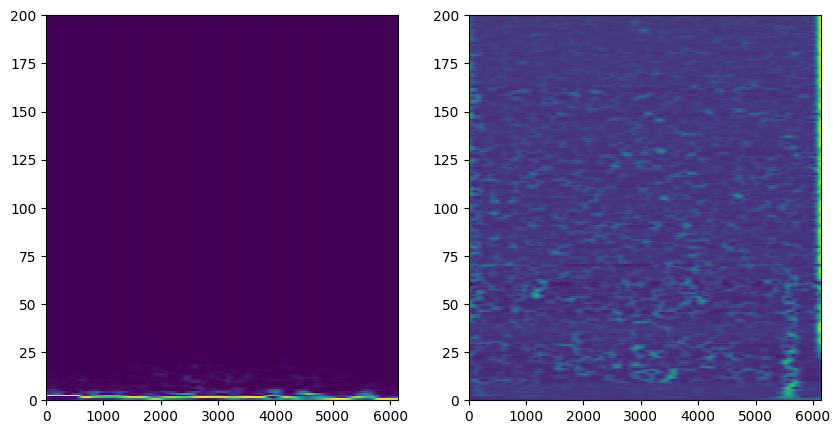

In [40]:
time_freq_map, freq = custom_dataset.compute_wavelet_transform(data, srate=2048, max_freq=1000)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
ax[0].pcolormesh(stats.zscore(time_freq_map[:,:],axis=0))
ax[1].pcolormesh(stats.zscore(time_freq_map[:,:],axis=1))

## CWT Features

In [44]:
image = features.get_CWT_features(data, 2048)
image.shape

(5, 6094)

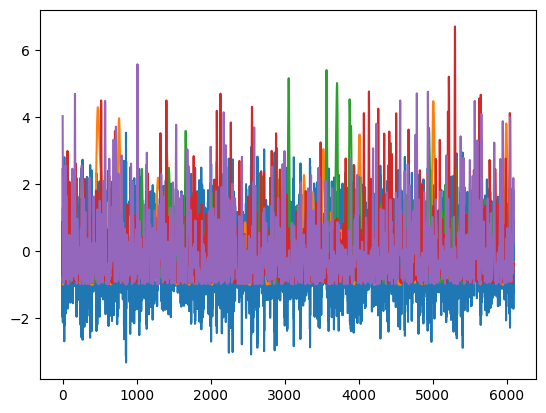

In [45]:
plt.plot(image[:,:].T)

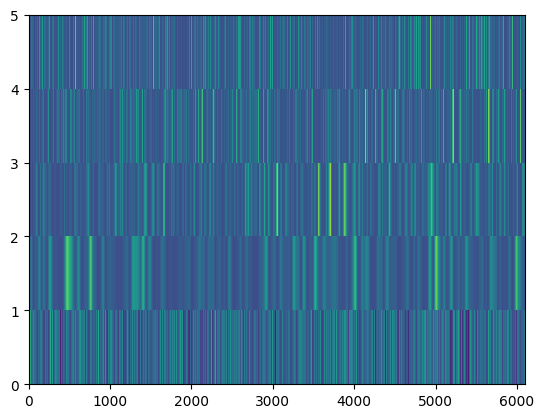

In [46]:
plt.pcolormesh(image[:,:])

## Hilbert transform

In [9]:
features = 'Hilbert'
assert features in ['DWT','CWT','Hilbert']

In [3]:
image_h = features.get_Hilbert_features(data, 2048)
image_h.shape

caca


(5, 6144)

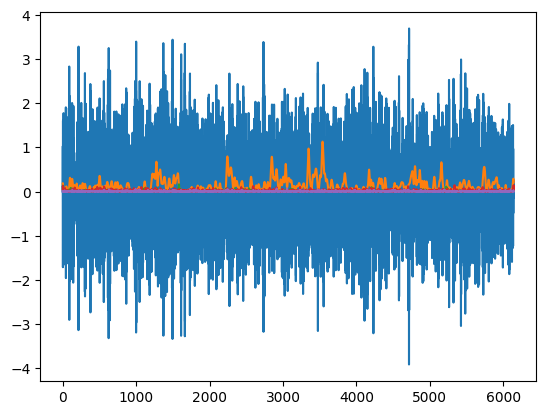

In [42]:
plt.plot(image_h.T)

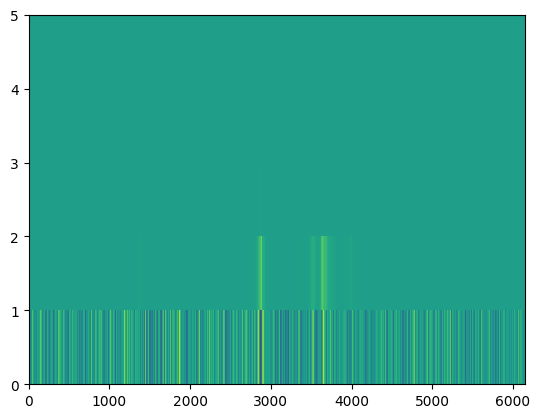

In [32]:
plt.pcolormesh(image_h[:,:])